In [45]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import  r_regression, SelectKBest


from woodwork.logical_types import Categorical, Boolean
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime
from math import sqrt, log10, ceil
'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

In [46]:


df = pd.read_csv('Google-Playstore(new).csv')

# 필요없는 컬럼 버리기
df = df.drop(['Unnamed: 0', 'App Name', 'App Id', 'Installs', 'Minimum Installs', 'Price', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Last Updated', 'Editors Choice', 'Scraped Time', 'Free'], axis=1)

# 숫자로 되어 있지 않은 컬럼 숫자로 인코딩하기
encoding = OrdinalEncoder()
encoding.fit(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']])
df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']] = encoding.transform(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases']])

# Size 컬럼 인코딩
A = df[df['Size'] == 'Varies with device'].index
df = df.drop(A,axis='index')
df = df.dropna()  # NaN가 포함된 데이터는 모두 drop
# 앱 크기 사이즈 계산
# 1. ','drop
# 2. M과 k drop
# 3. k값 M으로 치환
df['Size'] =  np.where(df['Size'].str.contains('M'), df['Size'].str.replace(',','').str[:-1].astype('float64') , df['Size'].str.replace(',','').str[:-1].astype('float64')/1000)

# 날짜 월만 남기고 버리고 인코딩
df['Released'] = pd.to_datetime(df['Released'])
df['Released'].dt.strftime('%b %d, %Y')
df['Released'] = df['Released'].dt.strftime('%Y-%m-%d')

df.fillna(df.mean(), inplace=True)

In [47]:
df

,Category,Rating,Rating Count,Maximum Installs,Size,Minimum Android,Released,Content Rating,Ad Supported,In App Purchases
0,26.0,4.9,20.0,552,5.8,27.0,2020-03-05,0.0,1.0,0.0
1,31.0,4.6,719.0,118989,12.0,21.0,2016-03-24,0.0,1.0,0.0
2,24.0,0.0,0.0,85,8.9,22.0,2018-12-25,0.0,0.0,0.0
3,11.0,0.0,0.0,723,27.0,27.0,2020-04-18,0.0,1.0,0.0
4,33.0,0.0,0.0,153,6.0,27.0,2017-11-27,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
19995,17.0,4.0,5.0,335,6.9,25.0,2018-08-14,0.0,1.0,0.0
19996,13.0,0.0,0.0,900,8.9,21.0,2017-08-10,0.0,0.0,0.0
19997,20.0,0.0,0.0,30,2.0,19.0,2020-01-03,0.0,0.0,0.0
19998,2.0,0.0,0.0,10,32.0,27.0,2019-09-16,0.0,1.0,0.0


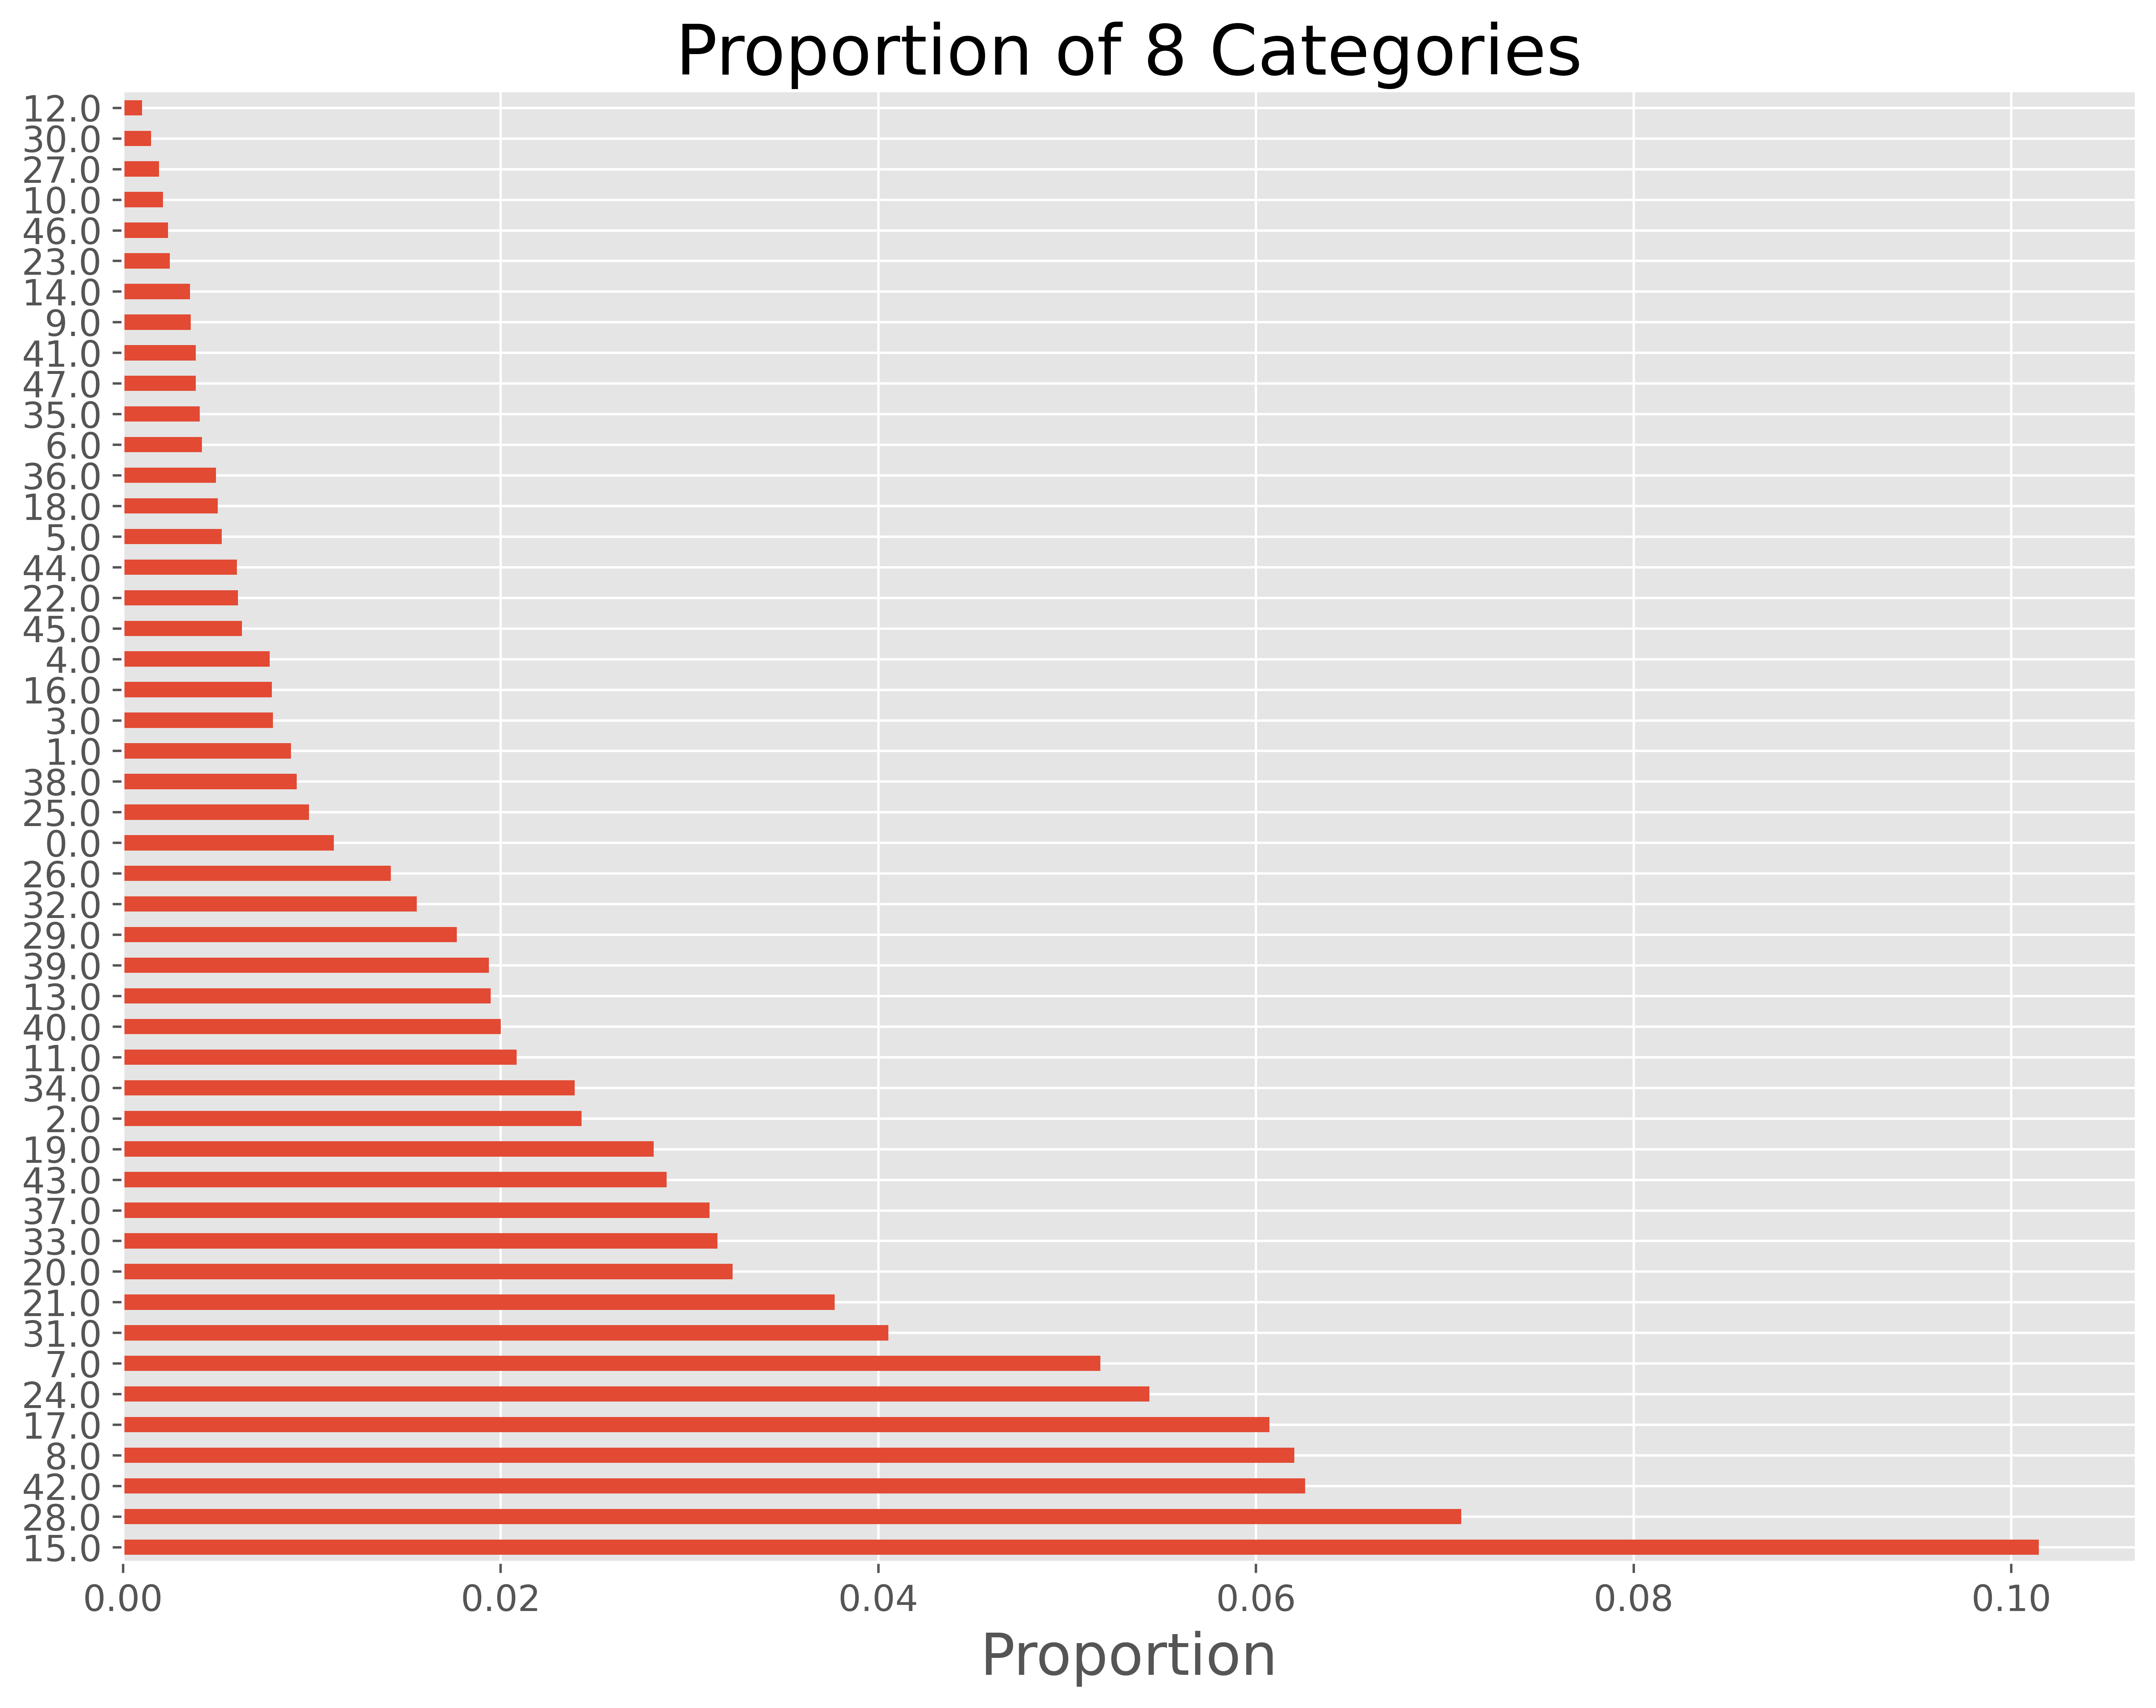

In [48]:
fig, ax = plt.subplots()

# Plot a normalized countplot
df['Category'].value_counts(normalize=True).plot.barh()

# Label
ax.set(title='Proportion of 8 Categories',
       xlabel='Proportion', ylabel='')

plt.show();


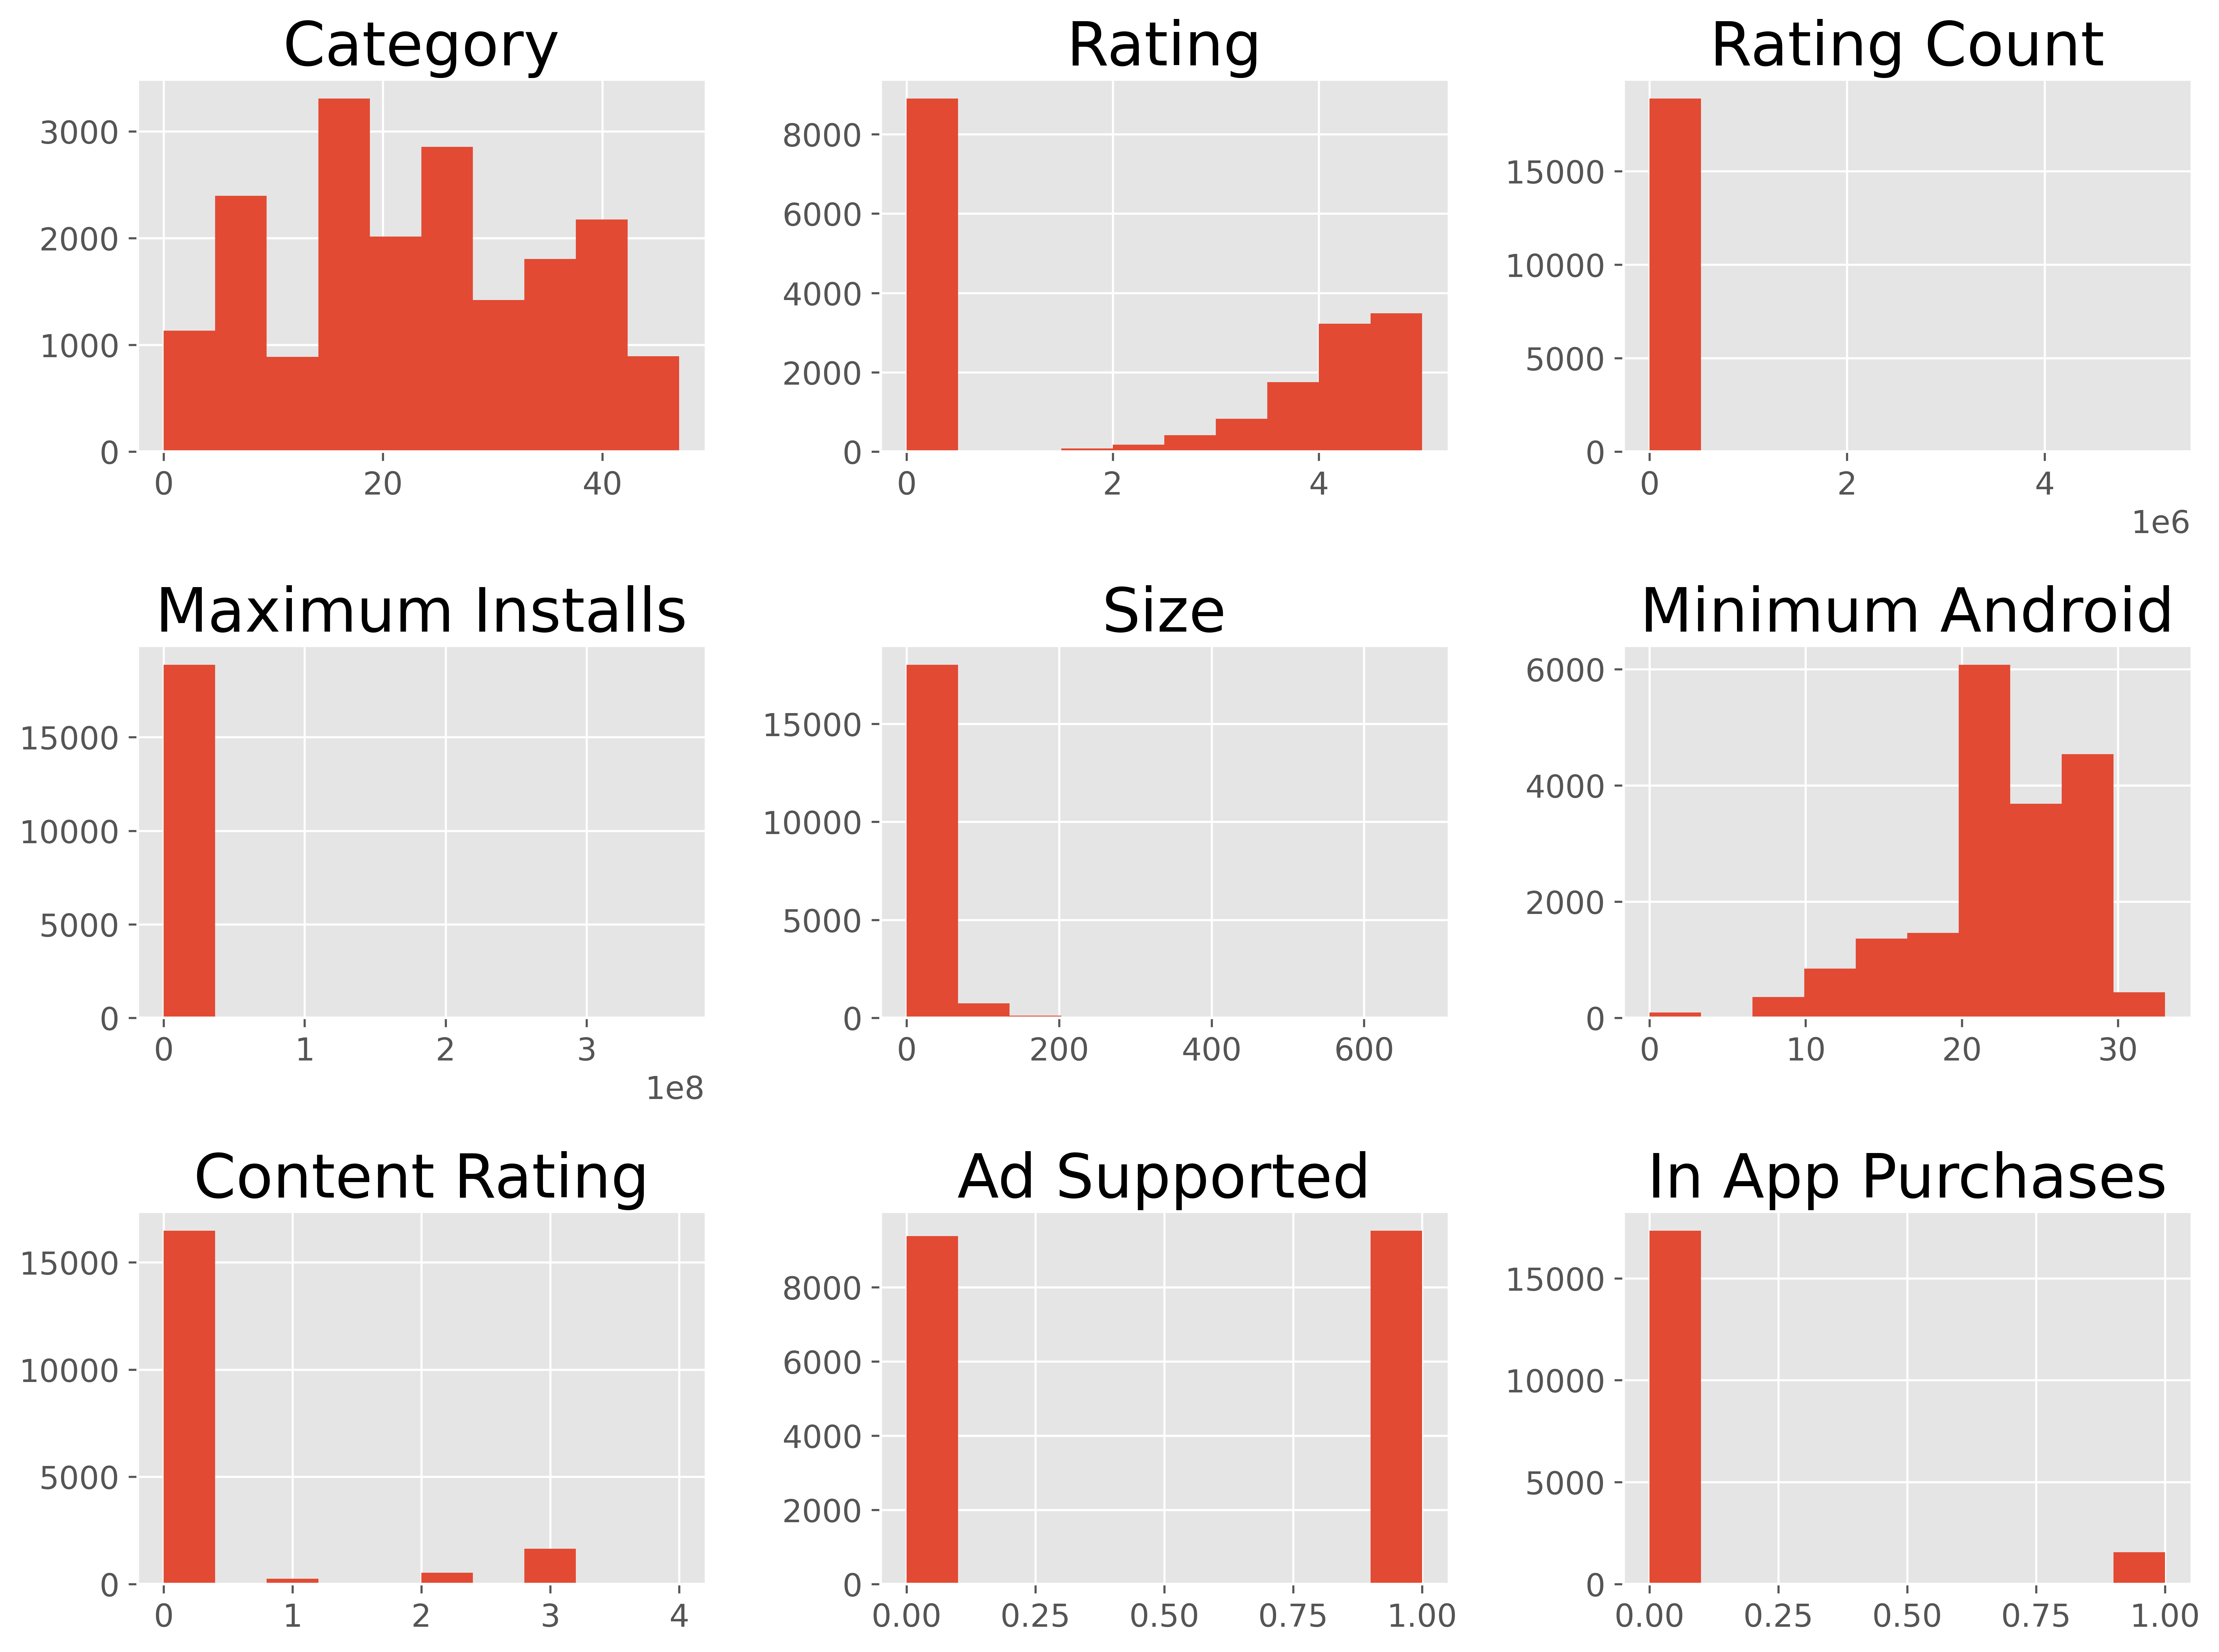

In [49]:
def make_subplot_layout(df, col_num):
    k = len(df.columns)
    row_num = ceil(k/col_num)
    for i in range(k) :
        plt.subplot(row_num,col_num,i+1)
        plt.hist(df.iloc[:,i])
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

make_subplot_layout(df.drop('Released', axis=1, inplace=False), 3)

In [50]:
es = ft.EntitySet(id='Store')
df["index"] = df.index

In [51]:
es.add_dataframe(dataframe_name="store_log",
                 dataframe=df,
                 index="index",
                 logical_types= {
                     "Ad Supported": Boolean,
                     "In App Purchases": Boolean,
                     "Category": Categorical,
                     "Minimum Android": Categorical
                 })

Entityset: Store
  DataFrames:
    store_log [Rows: 18893, Columns: 11]
  Relationships:
    No relationships

In [52]:
#Check dataset schema briefly
es["store_log"].ww.schema

,Logical Type,Semantic Tag(s)
Column,,
Category,Categorical,['category']
Rating,Double,['numeric']
Rating Count,Double,['numeric']
Maximum Installs,Integer,['numeric']
Size,Double,['numeric']
Minimum Android,Categorical,['category']
Released,Datetime,[]
Content Rating,Double,['numeric']
Ad Supported,Boolean,[]


In [53]:
pd.set_option('display.max_rows', 20)
ft.list_primitives()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,all,aggregation,True,False,Calculates if all values are 'True' in a list.,"<ColumnSchema (Logical Type = Boolean)>, <Colu...",None
1,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` ...",<ColumnSchema (Semantic Tags = ['numeric'])>,None
2,last,aggregation,False,False,Determines the last value in a list.,<ColumnSchema>,None
3,mean,aggregation,True,True,Computes the average for a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
4,percent_true,aggregation,True,False,Determines the percent of `True` values.,<ColumnSchema (Logical Type = BooleanNullable)...,None
...,...,...,...,...,...,...,...
96,cosine,transform,True,True,Computes the cosine of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
97,url_to_domain,transform,False,False,Determines the domain of a url.,<ColumnSchema (Logical Type = URL)>,None
98,month,transform,True,True,Determines the month value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,None
99,less_than_equal_to_scalar,transform,True,True,Determines if values are less than or equal to...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",None


In [54]:
'''

@Author: MinHyung Lee
@Since: 2022/05/23
새로운 feature(년, 월, 일)생성하기 위해 dfs 사용

'''


features, feature_names = ft.dfs(entityset=es,
                                 target_dataframe_name='store_log',
                                 trans_primitives=['year', 'month', 'day'])

df = features

In [55]:
# 순서 바뀜

X = df.drop(["Maximum Installs","DAY(Released)","YEAR(Released)"], axis = 1)
y = df[['Maximum Installs']]
X

,Category,Rating,Rating Count,Size,Minimum Android,Content Rating,Ad Supported,In App Purchases,MONTH(Released)
index,,,,,,,,,
0,26.0,4.9,20.0,5.8,27.0,0.0,True,False,3
1,31.0,4.6,719.0,12.0,21.0,0.0,True,False,3
2,24.0,0.0,0.0,8.9,22.0,0.0,False,False,12
3,11.0,0.0,0.0,27.0,27.0,0.0,True,False,4
4,33.0,0.0,0.0,6.0,27.0,0.0,False,False,11
...,...,...,...,...,...,...,...,...,...
19995,17.0,4.0,5.0,6.9,25.0,0.0,True,False,8
19996,13.0,0.0,0.0,8.9,21.0,0.0,False,False,8
19997,20.0,0.0,0.0,2.0,19.0,0.0,False,False,1


In [56]:

select = SelectKBest(score_func= r_regression, k = "all")
fit = select.fit(X, y)

df_columns = pd.DataFrame(X.columns)
df_scores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ["Factors", 'Score']
print(featureScores.nlargest(9,'Score'))

            Factors     Score
2      Rating Count  0.537039
7  In App Purchases  0.072010
3              Size  0.044868
1            Rating  0.043350
6      Ad Supported  0.025747
4   Minimum Android  0.019505
0          Category  0.015156
5    Content Rating  0.006785
8   MONTH(Released) -0.000321


In [57]:
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=7) # 주성분을 몇개로 할지 결정
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.head()

,0,1,2,3,4,5,6
0,0.420669,-0.599718,-0.172223,0.019488,1.073894,-0.542920,0.419949
1,0.221266,-1.171208,0.034745,0.144579,1.232711,-0.502926,0.366912
2,-1.147918,0.704282,0.937972,0.267565,-1.355425,0.104966,-0.396214
3,-0.070334,0.656414,-1.255251,-0.206233,0.057792,0.515631,-0.837989
4,-0.962960,1.230620,1.504492,-0.068015,-0.768099,-0.045126,-0.540326


In [62]:
#Split dataset into train and test set seed to 7777 for same result

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state=7777)

In [63]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_predict_test = reg.predict(X_test)
print(log10(mean_squared_error(y_test, y_predict_test)))

11.758901148535513


RMSE value for k=  1 is: 21596741422147.164
RMSE value for k=  2 is: 5499314568337.459
RMSE value for k=  3 is: 3159833235724.4663
RMSE value for k=  4 is: 2375168025234.6147
RMSE value for k=  5 is: 1806829593605.6904
RMSE value for k=  6 is: 968177328856.453
RMSE value for k=  7 is: 629774943847.5521
RMSE value for k=  8 is: 506290072346.1133
RMSE value for k=  9 is: 405291918347.83984
RMSE value for k=  10 is: 368790390898.333
RMSE value for k=  11 is: 349406441689.4146
RMSE value for k=  12 is: 338819275842.26514
RMSE value for k=  13 is: 370617564908.2502
RMSE value for k=  14 is: 356573610689.5597
RMSE value for k=  15 is: 355088869615.53546
RMSE value for k=  16 is: 355760856009.8034
RMSE value for k=  17 is: 362531577206.18713
RMSE value for k=  18 is: 378358195324.8427
RMSE value for k=  19 is: 401076288102.8933
RMSE value for k=  20 is: 425006004394.98364
RMSE value for k=  21 is: 451251566689.9813
RMSE value for k=  22 is: 474395060764.07886
RMSE value for k=  23 is: 5044573

<AxesSubplot:>

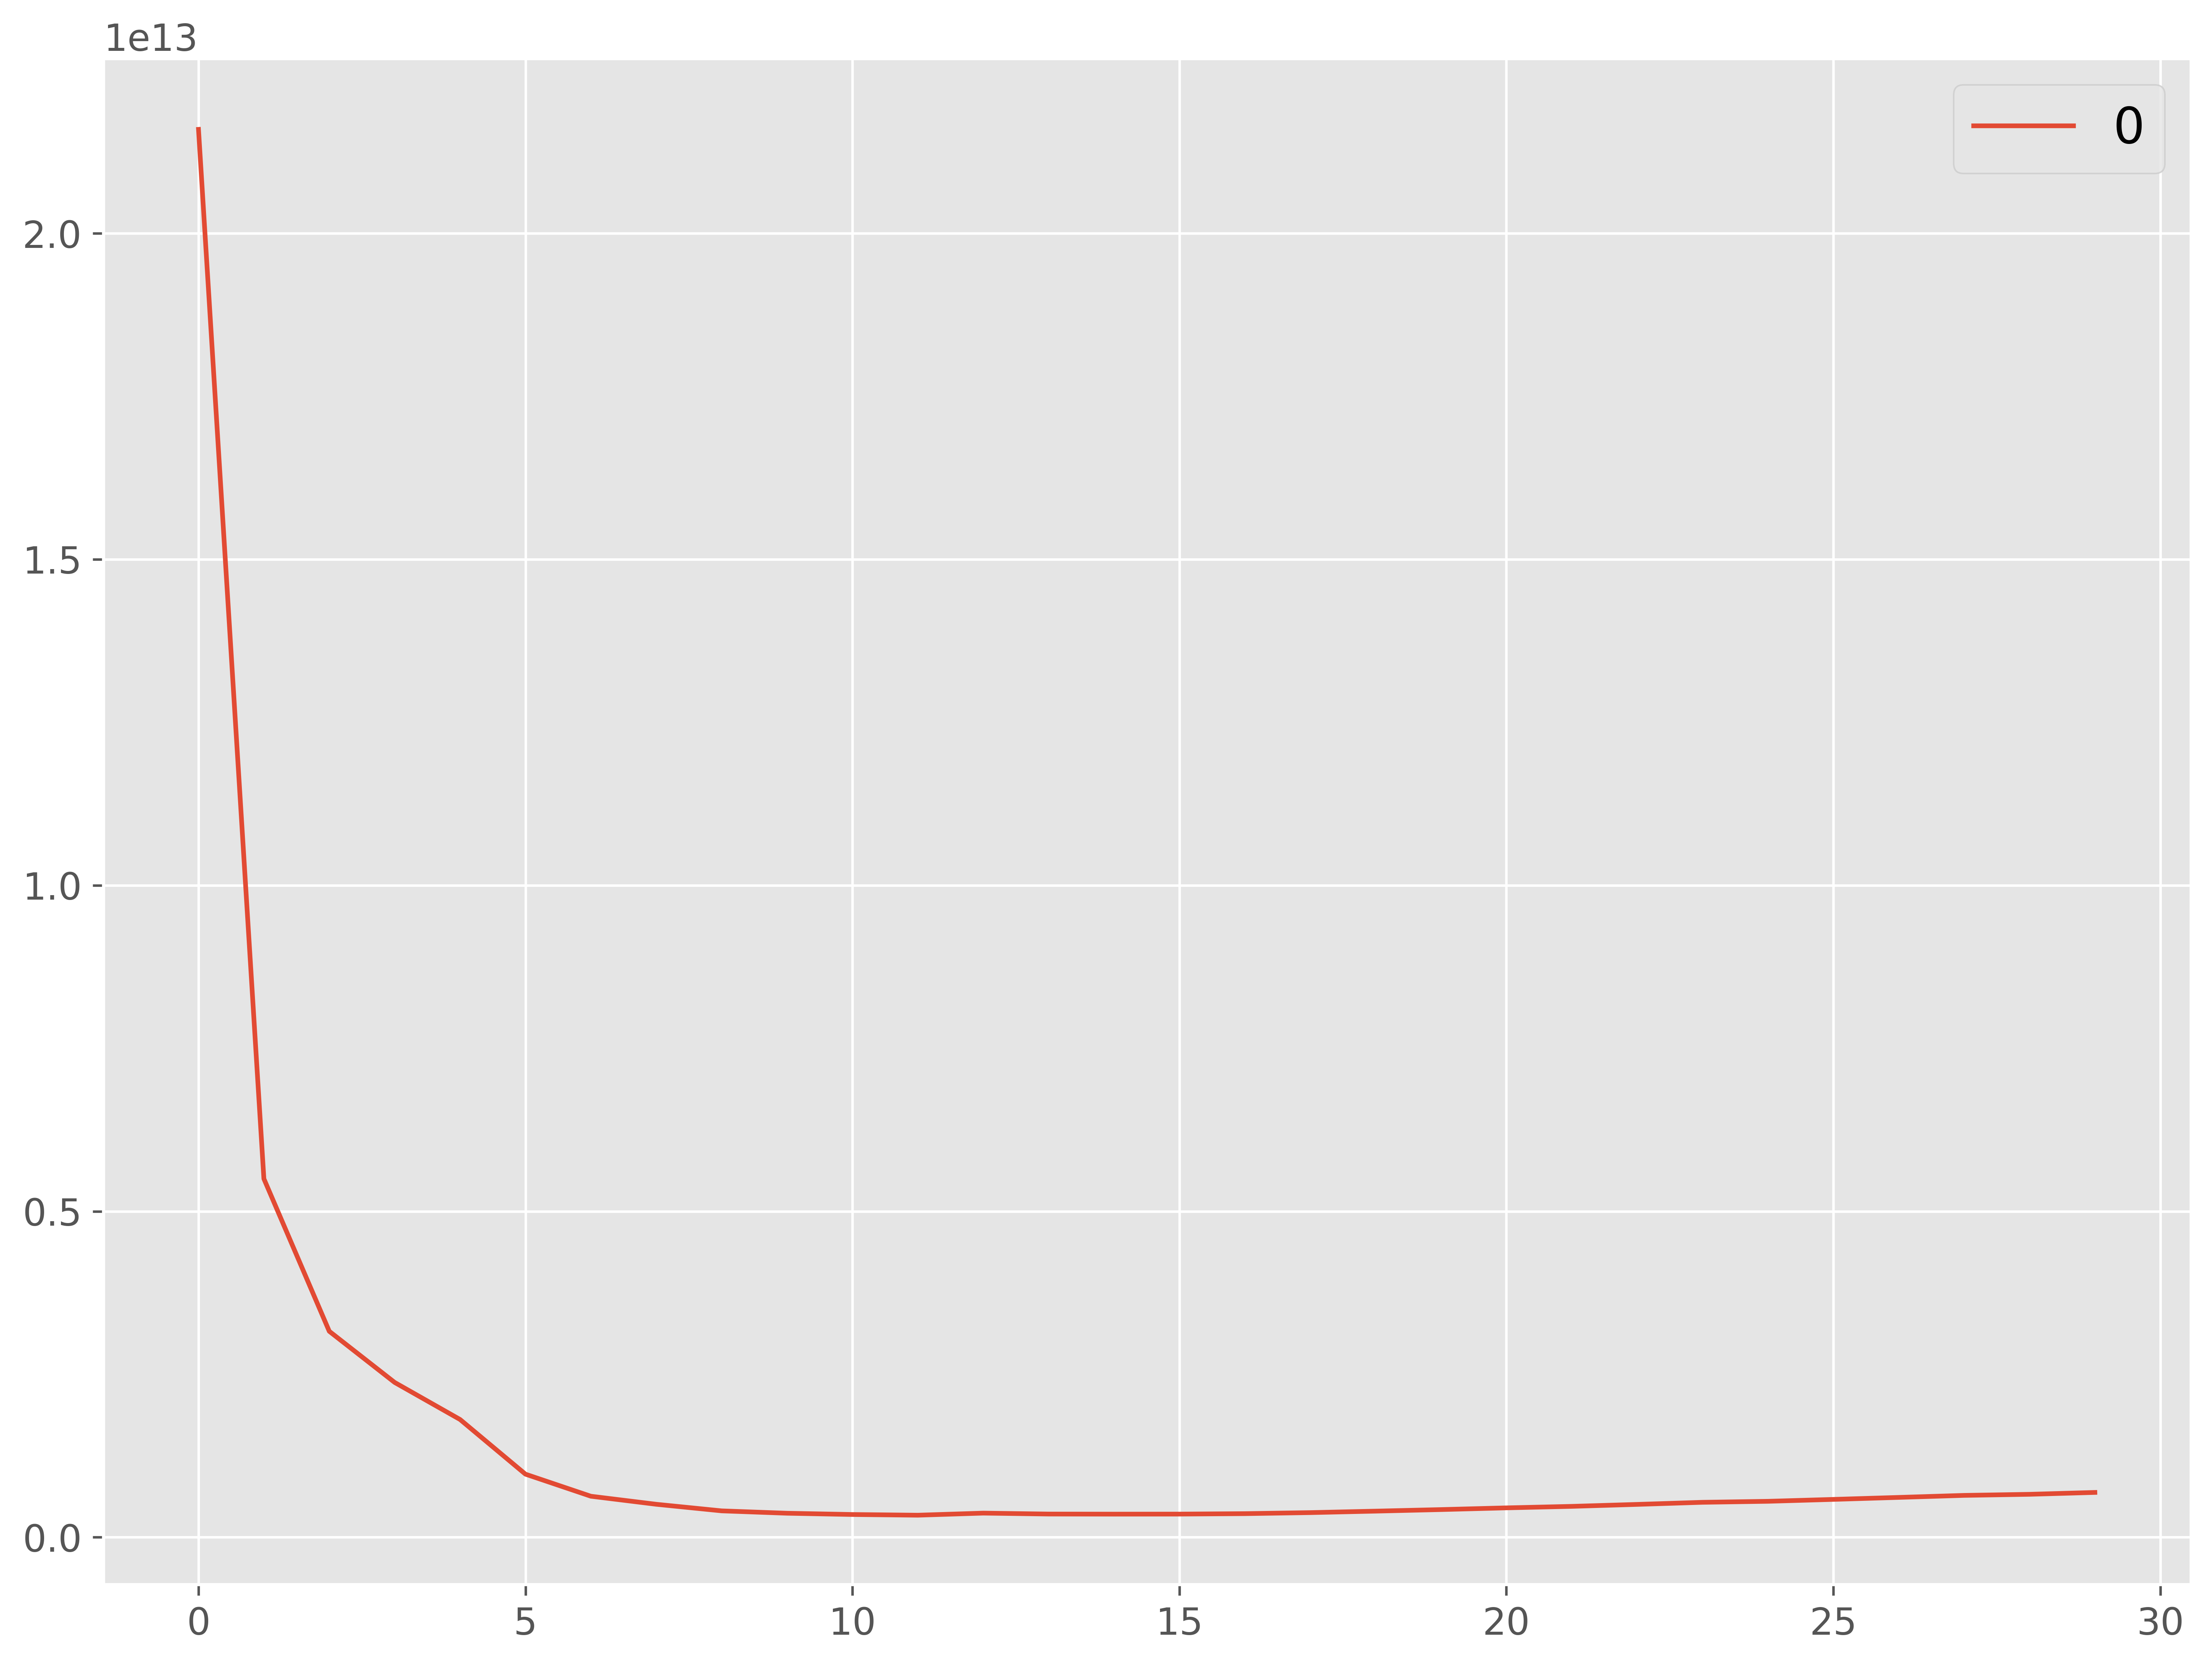

In [64]:
# Normal MSE

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()

RMSE value for k=  1 is: 13.334388228505638
RMSE value for k=  2 is: 12.740308562632556
RMSE value for k=  3 is: 12.499664162771642
RMSE value for k=  4 is: 12.375694338108687
RMSE value for k=  5 is: 12.25691719514727
RMSE value for k=  6 is: 11.985954908848335
RMSE value for k=  7 is: 11.799185377854648
RMSE value for k=  8 is: 11.704399411551226
RMSE value for k=  9 is: 11.60776794385536
RMSE value for k=  10 is: 11.566779596670646
RMSE value for k=  11 is: 11.54333090741388
RMSE value for k=  12 is: 11.52996810990482
RMSE value for k=  13 is: 11.568925998258534
RMSE value for k=  14 is: 11.552149198749634
RMSE value for k=  15 is: 11.550337059402958
RMSE value for k=  16 is: 11.5511581614147
RMSE value for k=  17 is: 11.559345840449451
RMSE value for k=  18 is: 11.577903145323038
RMSE value for k=  19 is: 11.603226986961767
RMSE value for k=  20 is: 11.628395065714283
RMSE value for k=  21 is: 11.654418722733398
RMSE value for k=  22 is: 11.676140158657066
RMSE value for k=  23 is:

<AxesSubplot:>

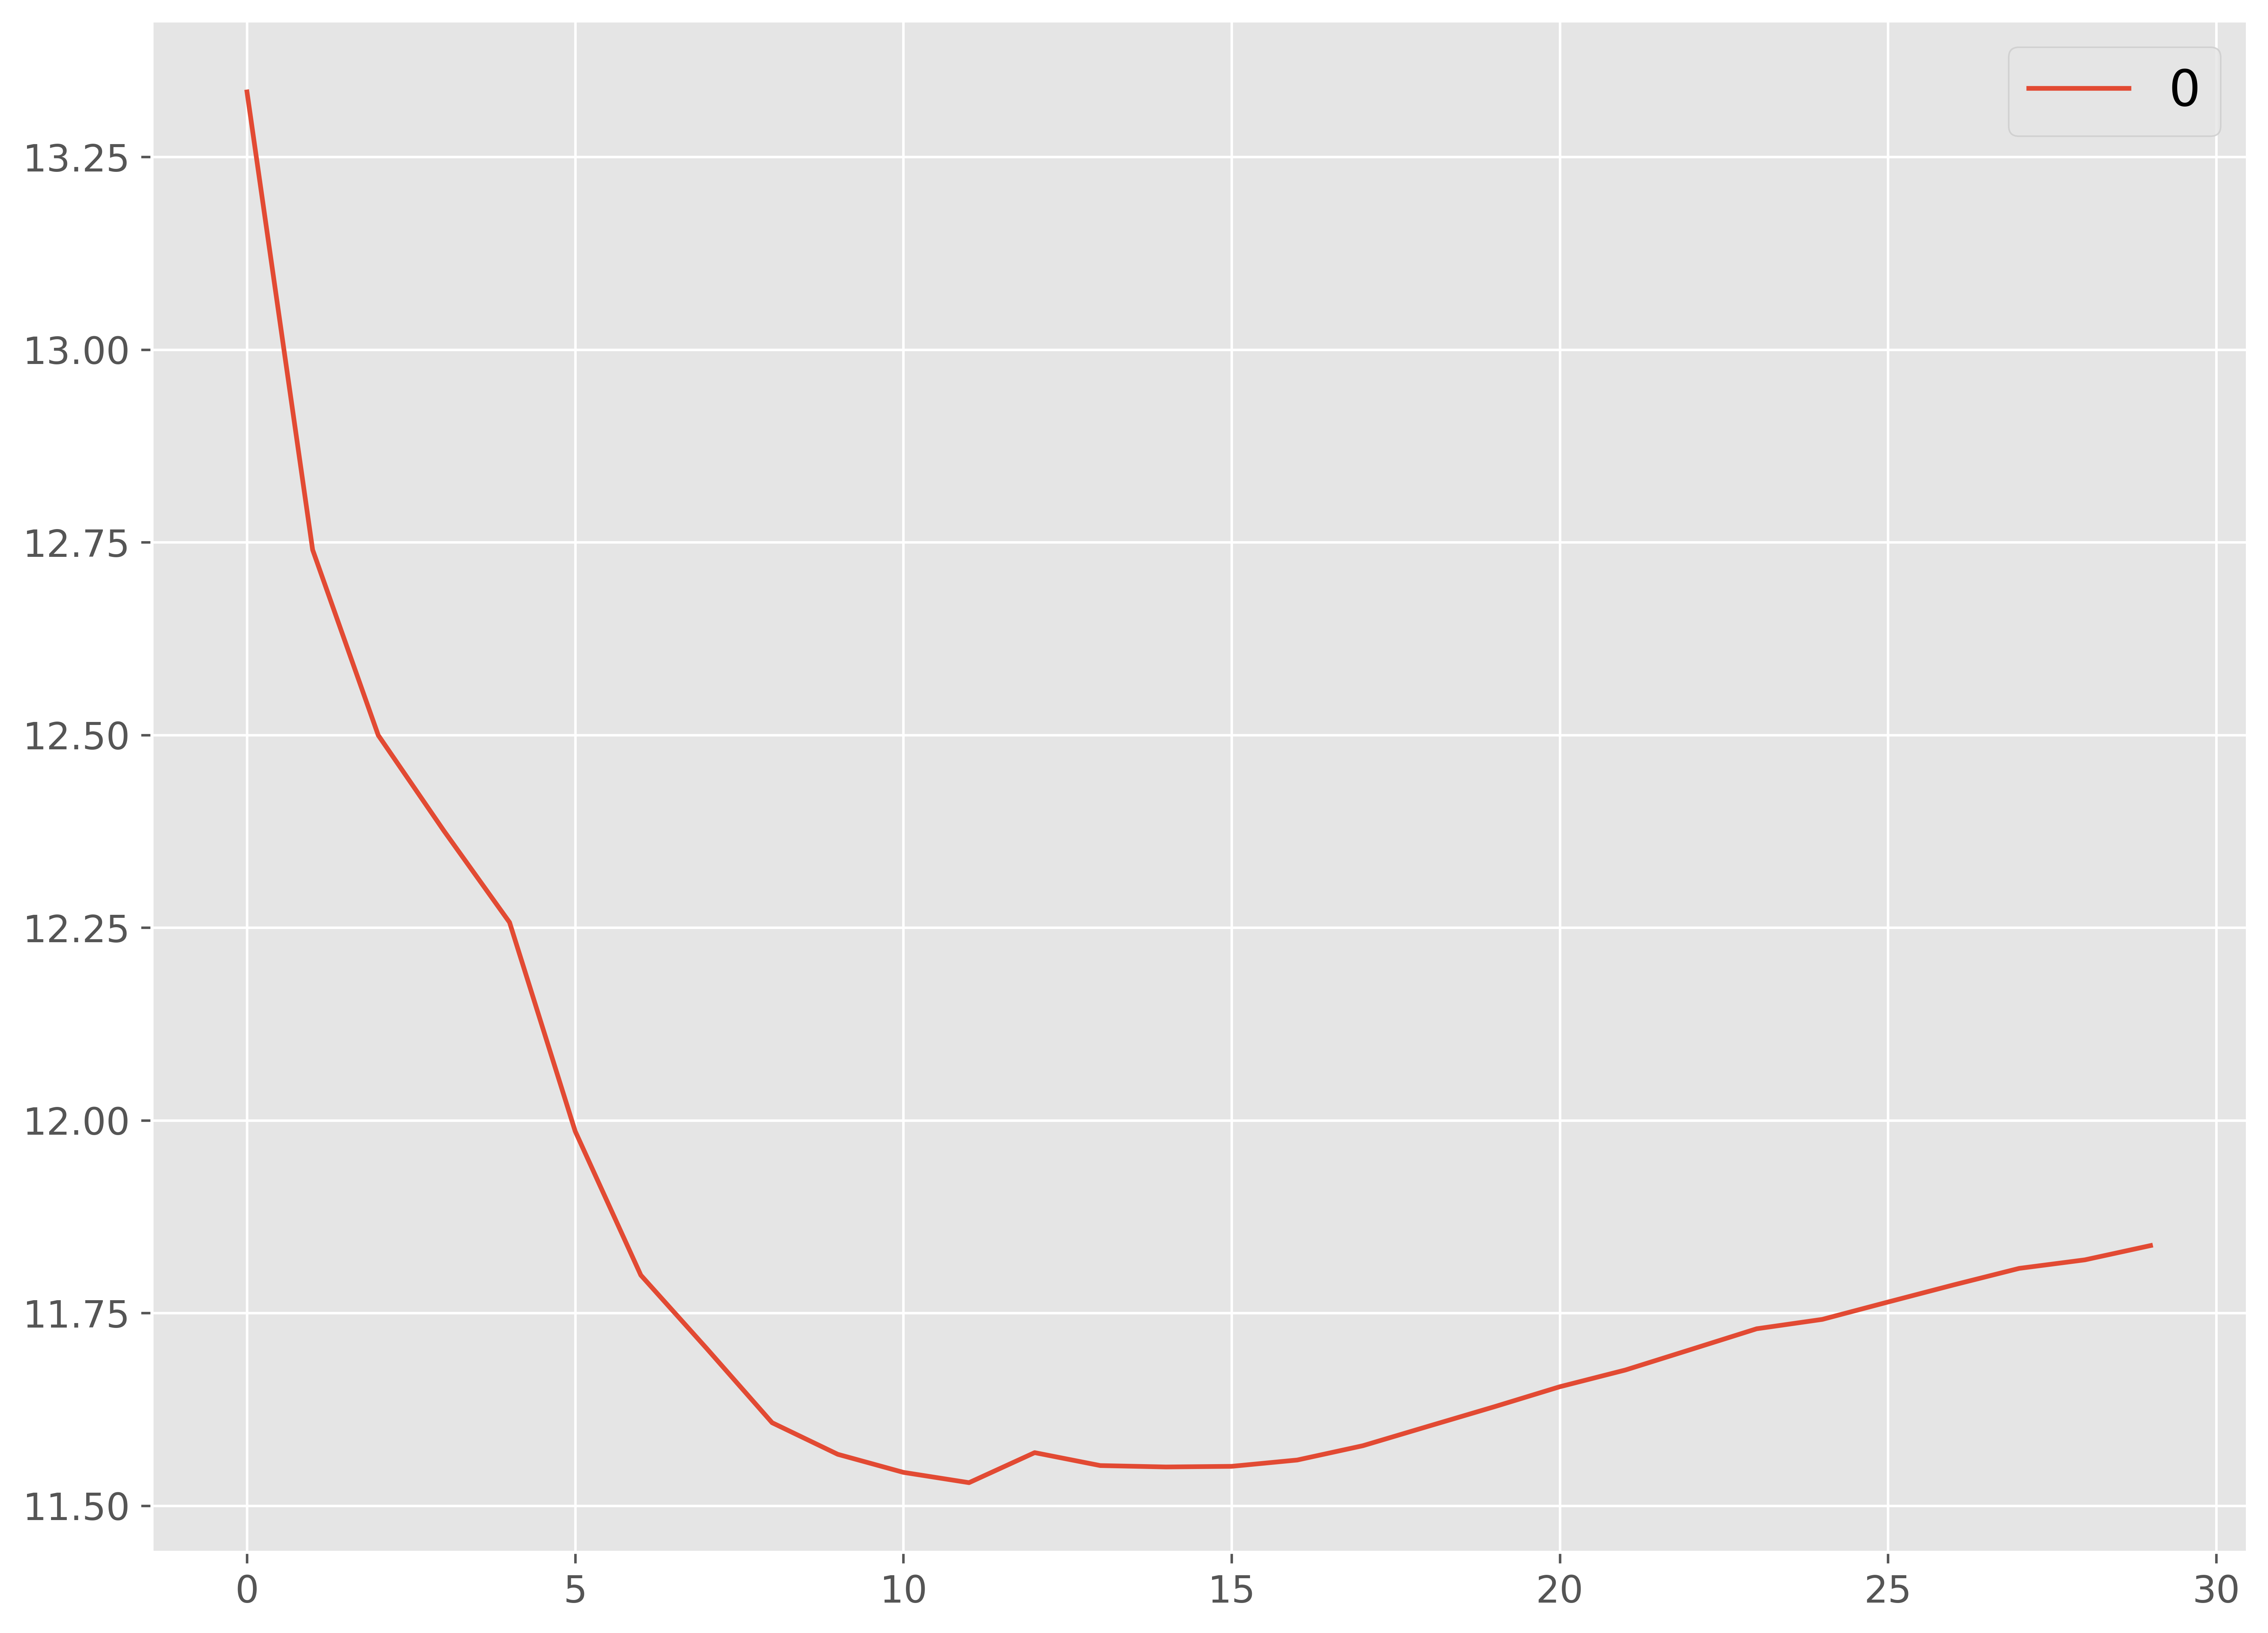

In [65]:
# MSE with log scale

rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = log10(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()